<a href="https://colab.research.google.com/github/Hienquang/SpringBoard/blob/main/take_home_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install pycaret

In [48]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from pycaret.classification import *
from sklearn.model_selection import train_test_split


# Part 1 - Exploratory Data Analysis


In [49]:
#load data
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [50]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [51]:
#group by 15 minutes
logins['by_15mins'] = logins['login_time'].dt.round('15min')  
by_15mins = logins.groupby(by=["by_15mins"])["login_time"].count()
by_15mins.head()

by_15mins
1970-01-01 20:15:00    6
1970-01-01 20:30:00    8
1970-01-01 20:45:00    7
1970-01-01 21:00:00    3
1970-01-01 21:15:00    4
Name: login_time, dtype: int64

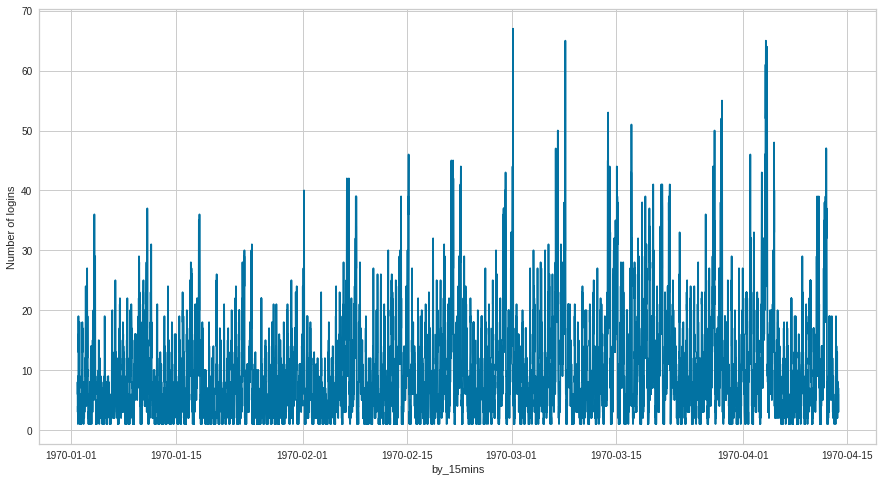

In [52]:
#plot
plt.figure(figsize = (15,8))
plt.ylabel("Number of logins")
sns.lineplot(data=by_15mins);


In [53]:
# group by date
logins['by_date'] = logins['login_time'].dt.round('D')  
by_date = logins.groupby(by=["by_date"])["login_time"].count()
by_date.head()

by_date
1970-01-02    403
1970-01-03    792
1970-01-04    904
1970-01-05    480
1970-01-06    452
Name: login_time, dtype: int64

Text(0, 0.5, 'Number of logins')

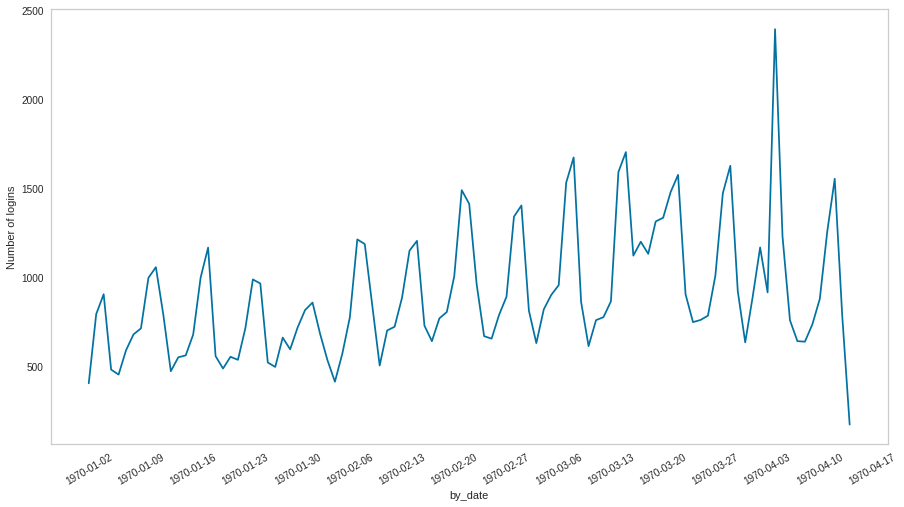

In [54]:
#plot
plt.figure(figsize = (15,8))
plt.grid()

ax = sns.lineplot(data=by_date)

# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7)) 

# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation = 30)

plt.ylabel("Number of logins")

There seems to be a clear surge in logins during the weekend followed by sharp drop-offs. Note: 1970-01-01 is a Thursday


In [55]:
#group by hour
by_15mins = by_15mins.to_frame()
by_15mins.reset_index(inplace=True)
by_15mins.columns = ['date_time','date_time_count']
by_15mins.head()

,date_time,date_time_count
0,1970-01-01 20:15:00,6
1,1970-01-01 20:30:00,8
2,1970-01-01 20:45:00,7
3,1970-01-01 21:00:00,3
4,1970-01-01 21:15:00,4


In [56]:
#find avg logins per 15 minutes segment 
by_15mins['time'] = by_15mins.date_time.dt.time
by_15mins_avg = by_15mins.groupby(by=["time"])["date_time_count"].mean()
by_15mins_avg.head()

time
00:00:00    14.676471
00:15:00    14.529412
00:30:00    14.735294
00:45:00    14.735294
01:00:00    14.794118
Name: date_time_count, dtype: float64

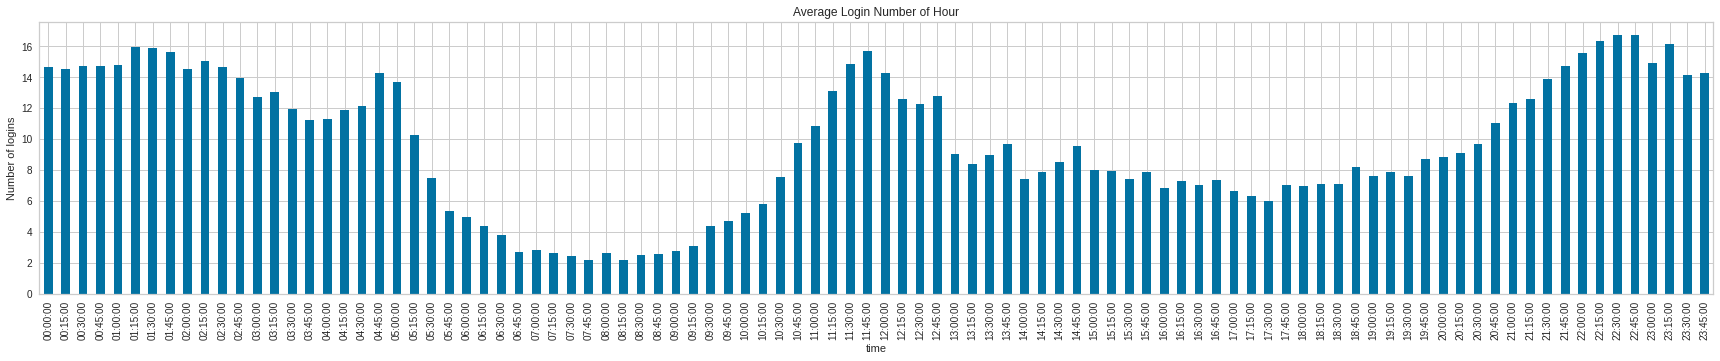

In [57]:
#plot
plt.figure(figsize = (30,5))

plt.title("Average Login Number of Hour")
plt.xlabel("Hour")
plt.ylabel("Number of logins")
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_tick_params(rotation = 90)

by_15mins_avg.plot(kind='bar');

Intesting. It seems like ther are 2 peaks: 1. before midnight until 5AM and 2. Around noon time

This above pattern seems to confirm what we already know:
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

# Part 2 ‐ Experiment and metrics design

Key measure of success of this experiment in encouraging driver partners to serve both cities is toll cost pattern. An increase in toll cost on average would indicate that there are more drivers who are drivign between the two cities

A practical experiment designed to compare the effectiveness of the proposed change is as followed
1. Collect data of toll costs , date, time, total cost, direction, pickup city, drop off city.
2. Perform null hypothese testing to see if the relative change in key measure of success could be attribute to proposed change. Asssuming the key metric is rider retention, we are looking to see if reimbursing toll cost increase number of driver who serve both cities as well as if it increase rider retention
3. All stastical and analytical data will be summary in graphical representation to present to city operation team. Possible result/recommndation are based on whether reimbursing ihas the intended effect and if the intended effect leads to better rider retention.

# Part 3 ‐ Predictive modeling

## Data Wrangling

In [58]:
#load data
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [60]:
#fix missing values
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df.dropna(axis=0, inplace=True)
df = df.reset_index(drop=True)

In [61]:
# Convert dates to datetime format
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

## Exploratory Data Analysis

In [63]:
# Create box plots of all categorical, non-date data
categorical_features = ['city', 'phone', 'ultimate_black_user']

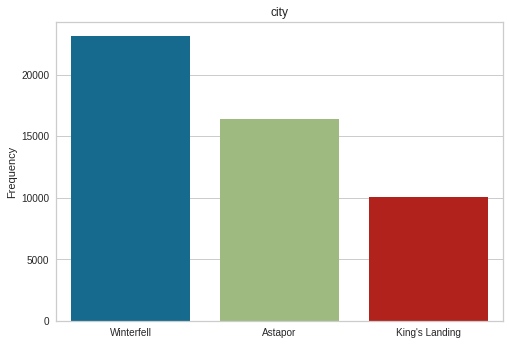

Winterfell        23125
Astapor           16413
King's Landing    10066
Name: city, dtype: int64


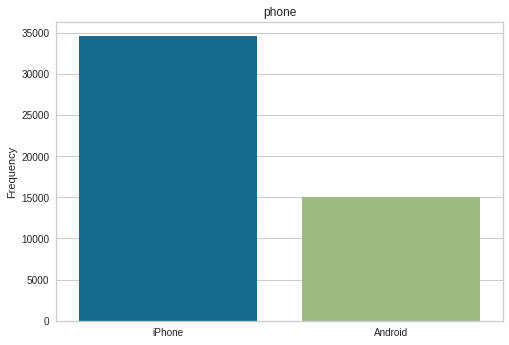

iPhone     34582
Android    15022
Name: phone, dtype: int64


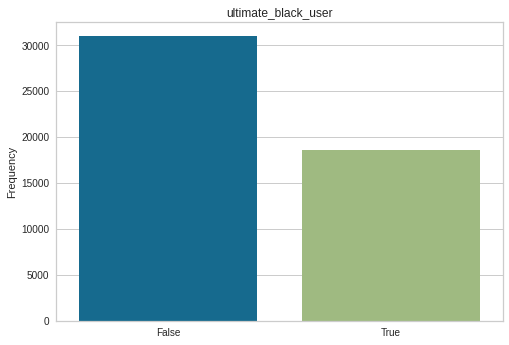

False    30992
True     18612
Name: ultimate_black_user, dtype: int64


In [64]:
for feature in categorical_features:
    sns.barplot(x = list(df[feature].value_counts().index), y = df[feature].value_counts())
    plt.title(feature)
    plt.ylabel('Frequency')
    plt.show()
    print(df[feature].value_counts())

In [65]:
# Show distributions of numerical features
numerical_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

<Figure size 2160x360 with 0 Axes>

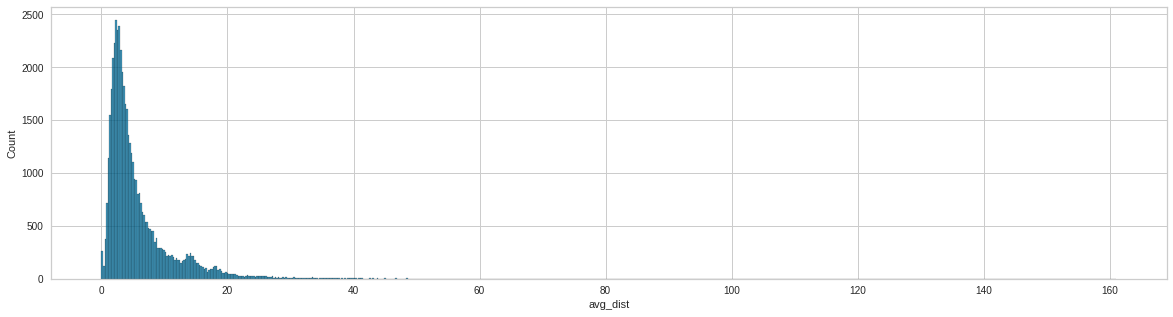

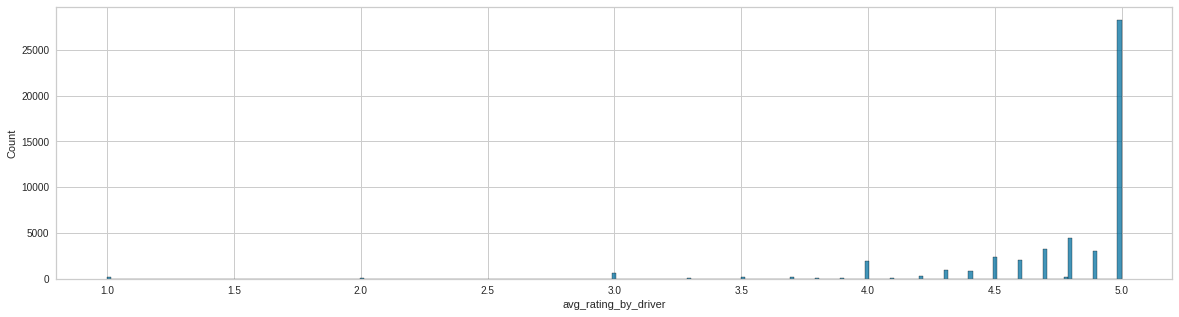

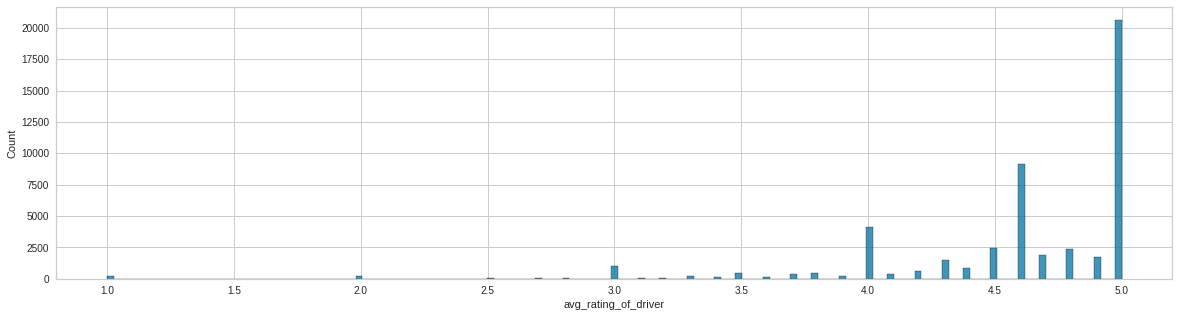

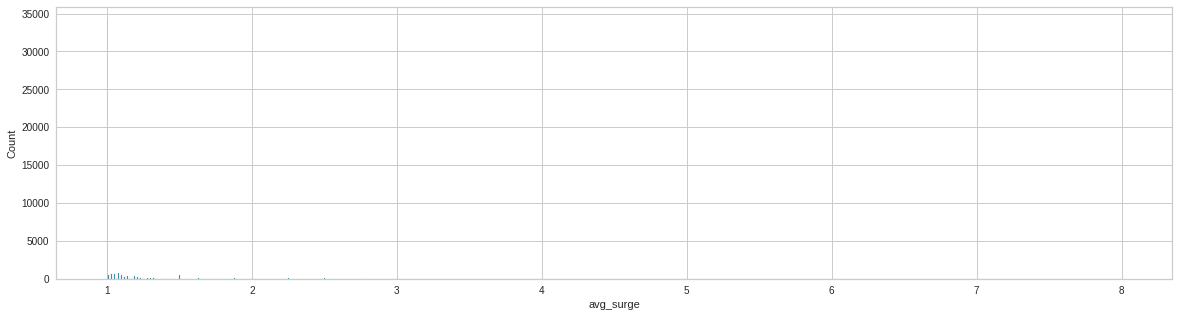

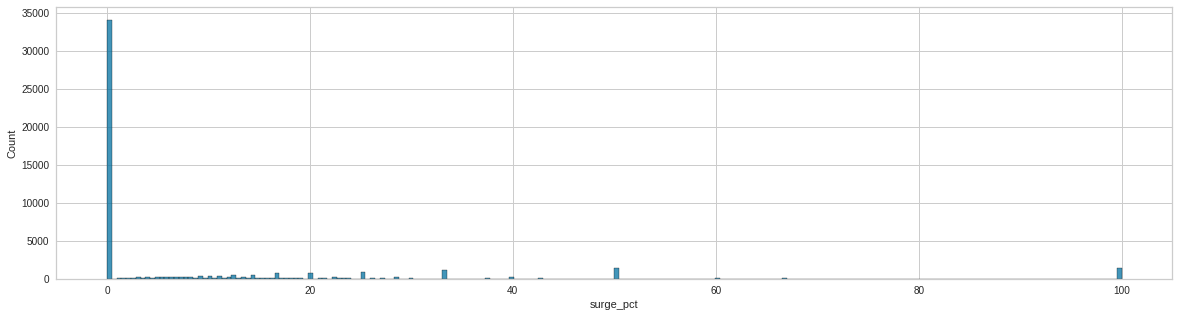

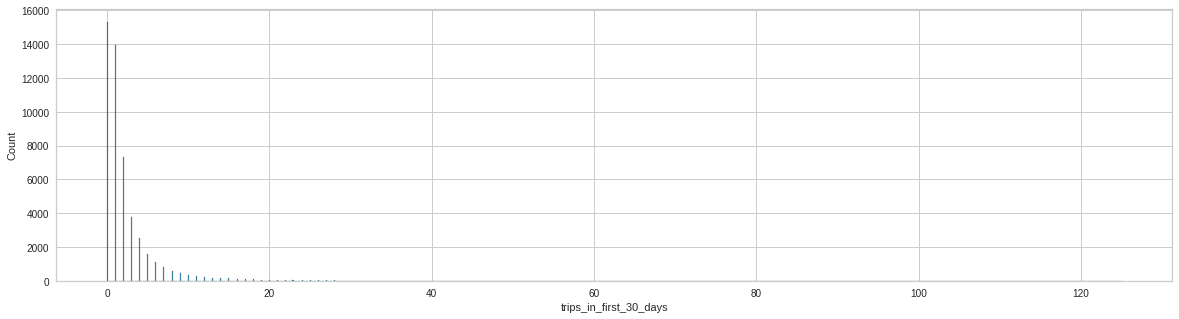

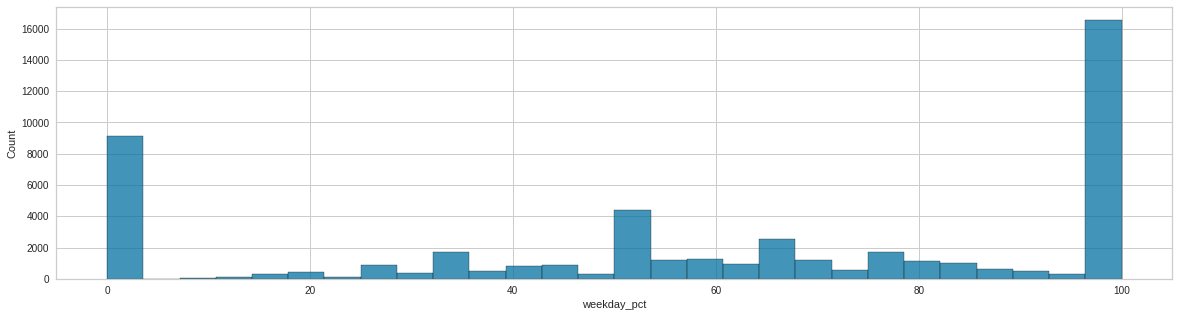

In [66]:
plt.figure(figsize = (30,5))
for feature in numerical_features:
  plt.figure(figsize = (20,5))
  sns.histplot(df[feature])
  plt.show();

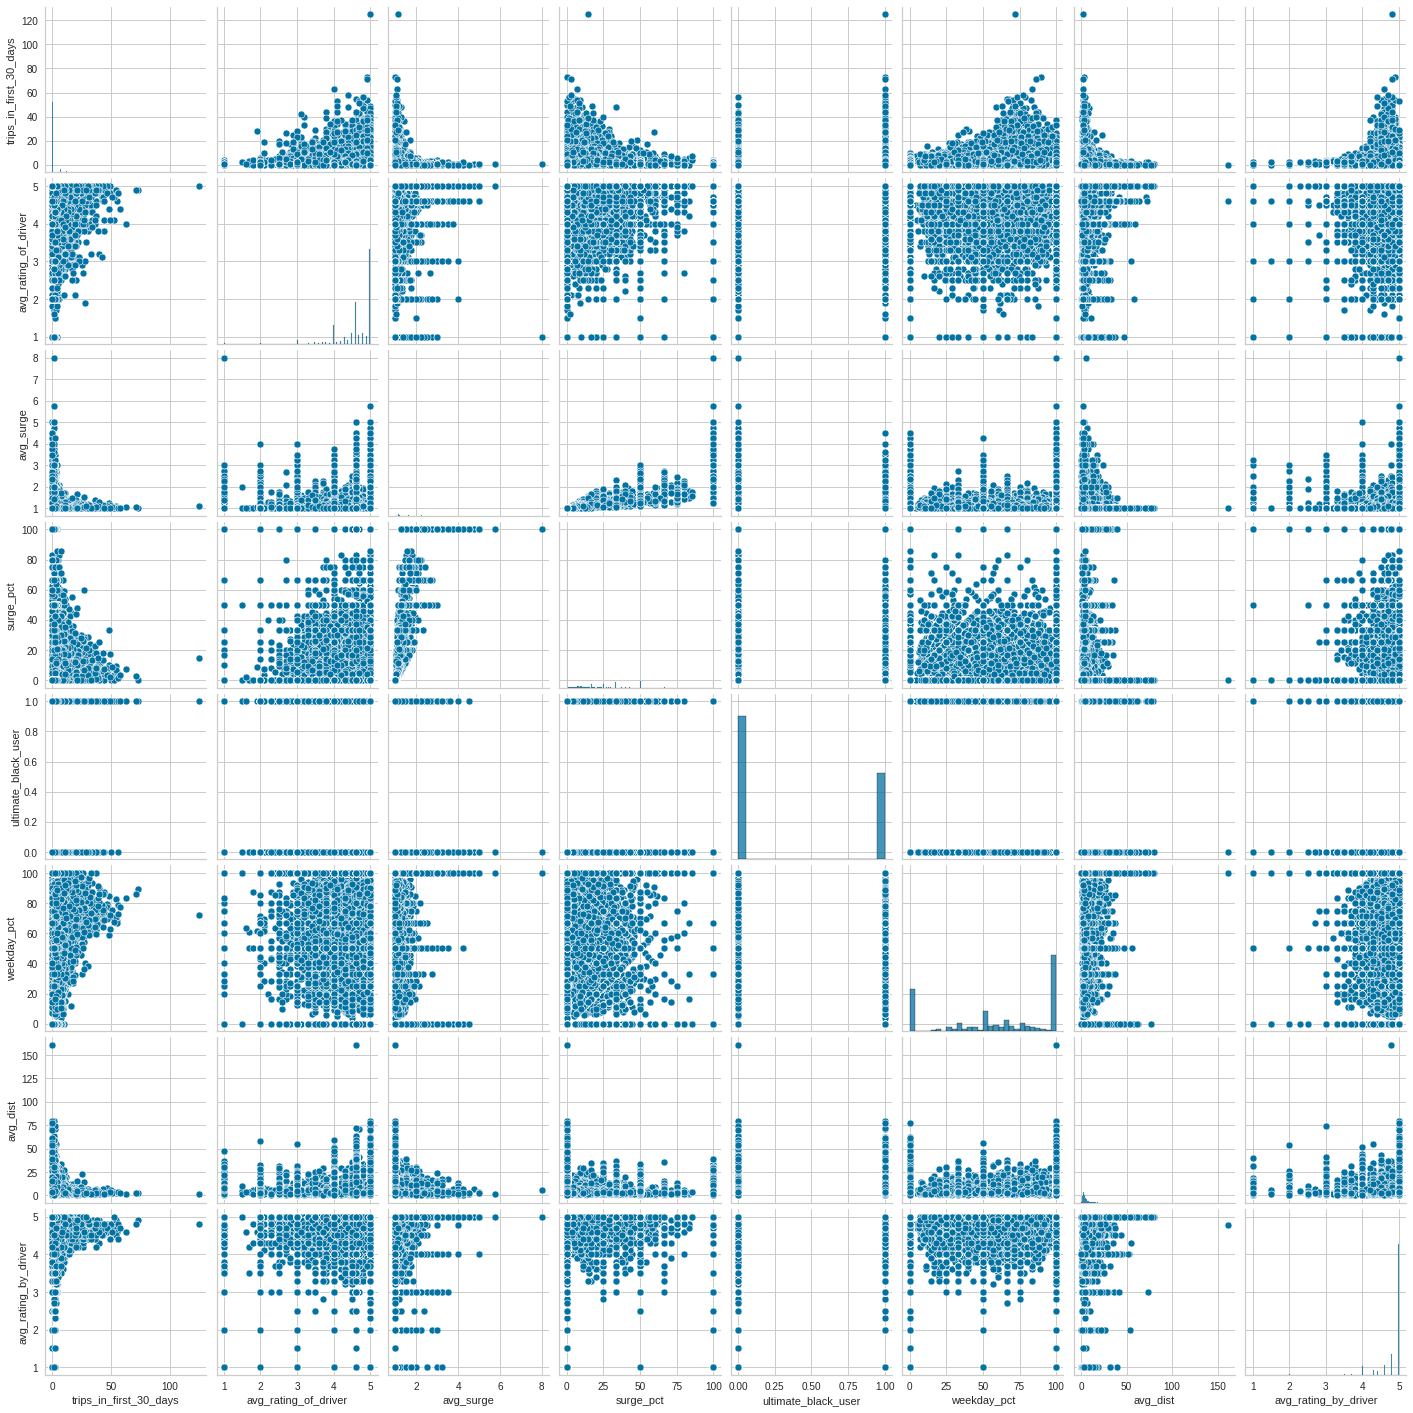

In [67]:

sns.pairplot(df);


Users in this sample dataset is signed up for an account in January 2014. This dataset was pulled several months later. Ia a user were active (took a trip in the preceding 30 days), they are considered retained.

In [68]:
df.sort_values(by='last_trip_date').tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
45166,King's Landing,2,2014-01-25,4.4,1.14,2014-07-01,Android,17.9,False,83.9,2.32,4.8
12053,King's Landing,16,2014-01-18,4.9,1.02,2014-07-01,Android,3.9,False,74.0,2.64,4.8
18667,Astapor,3,2014-01-10,4.7,1.02,2014-07-01,iPhone,3.2,False,67.7,6.22,4.8
11999,Winterfell,1,2014-01-24,4.7,1.04,2014-07-01,iPhone,15.4,True,38.5,6.80,4.9
31351,Winterfell,12,2014-01-19,4.9,1.07,2014-07-01,iPhone,6.0,True,70.0,5.63,4.7


In [69]:
frac = len(df[df['last_trip_date'] > '2014-06-01'])/len(df)
print('{:.2f}% of the observed users were retained.'.format(frac*100))

36.65% of the observed users were retained.


## Predictive Modeling

In [70]:
# Prepare data
df['retained'] = (df['last_trip_date'] > '2014-06-01')*1
df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
df = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'], drop_first=True)
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,1,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,1,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,0,0


In [71]:
#Use pycaret to compare models
exp_clf = setup(df, target = 'retained')
best_model = compare_models(fold=5, turbo=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7909,0.8583,0.6650,0.7418,0.7013,0.5412,0.5431,0.486
gbc,Gradient Boosting Classifier,0.7877,0.8531,0.6556,0.7398,0.6951,0.5332,0.5355,2.394
ada,Ada Boost Classifier,0.7821,0.8470,0.6433,0.7336,0.6854,0.5199,0.5226,0.874
rf,Random Forest Classifier,0.7603,0.8223,0.6549,0.6828,0.6685,0.4809,0.4812,3.028
et,Extra Trees Classifier,0.7512,0.8052,0.6597,0.6640,0.6618,0.4650,0.4651,2.812
knn,K Neighbors Classifier,0.7397,0.7819,0.6057,0.6609,0.6321,0.4313,0.4323,0.746
qda,Quadratic Discriminant Analysis,0.7282,0.7766,0.6951,0.6175,0.6538,0.4314,0.4337,0.062
nb,Naive Bayes,0.7254,0.7672,0.6625,0.6198,0.6404,0.4187,0.4193,0.060
lr,Logistic Regression,0.7224,0.7675,0.4992,0.6653,0.5704,0.3715,0.3798,1.740
ridge,Ridge Classifier,0.7220,0.0000,0.4757,0.6752,0.5581,0.3641,0.3760,0.056


In [72]:
# create Light gradient Bootsting Machine model
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7947,0.8621,0.6825,0.7409,0.7105,0.5519,0.5530
1,0.7878,0.8523,0.6630,0.7359,0.6976,0.5348,0.5365
2,0.7958,0.8601,0.6737,0.7478,0.7088,0.5522,0.5540
3,0.7831,0.8507,0.6370,0.7391,0.6843,0.5205,0.5238
4,0.7895,0.8631,0.6729,0.7342,0.7022,0.5399,0.5411
5,0.7952,0.8601,0.6698,0.7487,0.7070,0.5504,0.5524
6,0.8013,0.8686,0.6763,0.7592,0.7153,0.5635,0.5657
7,0.7909,0.8594,0.6763,0.7360,0.7049,0.5434,0.5446
8,0.7941,0.8629,0.6583,0.7529,0.7025,0.5461,0.5490
9,0.7883,0.8507,0.6576,0.7401,0.6964,0.5348,0.5370


In [73]:
#tune model
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7996,0.8634,0.6763,0.7552,0.7136,0.5602,0.5622
1,0.7881,0.8541,0.6513,0.7429,0.6941,0.5331,0.5357
2,0.7918,0.8611,0.6674,0.7422,0.7028,0.5433,0.5451
3,0.7866,0.8517,0.6409,0.7450,0.6890,0.5280,0.5314
4,0.7897,0.8632,0.6612,0.7410,0.6988,0.5381,0.5402
5,0.7923,0.8583,0.6620,0.7465,0.7017,0.5433,0.5456
6,0.8070,0.8717,0.6825,0.7689,0.7231,0.5758,0.5783
7,0.7938,0.8585,0.6778,0.7415,0.7082,0.5493,0.5506
8,0.7978,0.8627,0.6591,0.7613,0.7065,0.5535,0.5569
9,0.7958,0.8531,0.6607,0.7556,0.7050,0.5499,0.5528


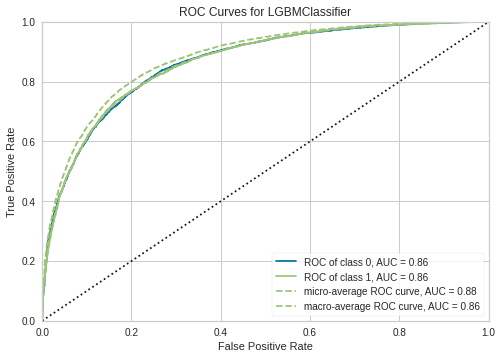

In [74]:
#plot_model
plot_model(estimator = tuned_lightgbm, plot = 'auc')

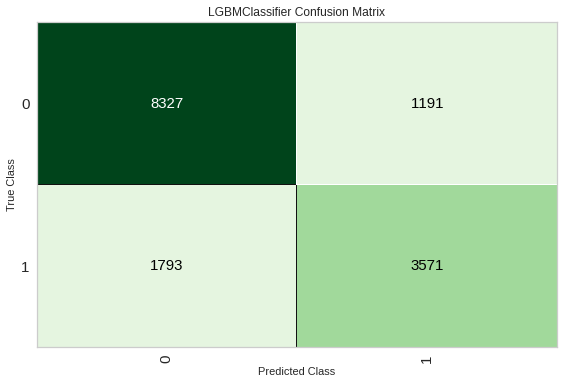

In [75]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

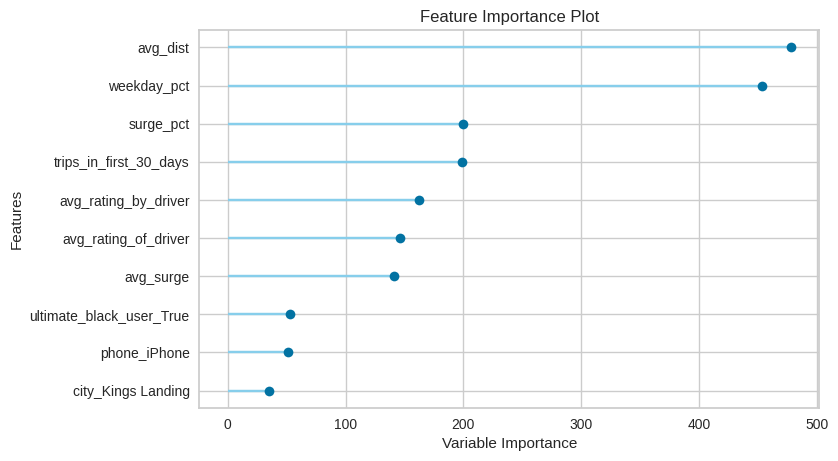

In [77]:
plot_model(tuned_lightgbm, plot = 'feature')

The feature that is most important in prediting whether a user will stay on is ave_dist and weekday_pct. Ave_dist is the average distance in miles per trip taken in the first 30 days after signup. Weekday_pct is the percent of the user’s trips occurring during a weekday. A quick recommendation for the team would be focusing on improve these two metrics